Here are the functions used during data preprocessing, training, and testing:

In [1]:
def train(model, input_ids, attention_mask, y_train_tensor, criterion, optimizer, epochs):
    running_acc = []

    for epoch in range(epochs):
        model.train()
        torch.cuda.empty_cache()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for input_ids, attention_mask, labels in train_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            # Accuracy
            _, predicted_labels = torch.max(outputs, dim=1)
            correct_predictions = (predicted_labels == labels).sum().item()
            total_correct += correct_predictions
            total_samples += labels.size(0)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Epoch metrics
        epoch_loss = total_loss / len(train_loader)
        epoch_acc = total_correct / total_samples
        running_acc.append(epoch_acc)


        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Plotting after training
    df_acc = pd.DataFrame({'Epochs': range(1, epochs + 1), 'Accuracy': running_acc})
    df_acc.plot(x='Epochs', y='Accuracy', kind='line', title='Training Accuracy Over Epochs', grid=True)




def test(model, test_loader, criterion, device, epochs):
    running_test_acc = []

    for epoch in range(epochs):
        model.eval()
        total_loss = 0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for input_ids, attention_mask, labels in test_loader:
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

                # Accuracy
                _, predicted_labels = torch.max(outputs, dim=1)
                correct_predictions = (predicted_labels == labels).sum().item()
                total_correct += correct_predictions
                total_samples += labels.size(0)

                total_loss += loss.item()

        # Epoch metrics
        epoch_loss = total_loss / len(test_loader)
        epoch_acc = total_correct / total_samples
        running_test_acc.append(epoch_acc)

        print(f'[Test] Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Plotting after testing
    df_test = pd.DataFrame({'Epochs': range(1, epochs + 1), 'Accuracy': running_test_acc})
    df_test.plot(x='Epochs', y='Accuracy', kind='line', title='Testing Accuracy Over Epochs', grid=True)

    return df_test


Import all the necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from transformers import AutoModel, AutoTokenizer
from transformers.models.bert.modeling_bert import BertIntermediate, BertOutput, BertEncoder, BertSelfAttention, BertSelfOutput, BertModel, BertConfig, BertPooler
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd


Import the question sets that will be used to train the model.  The first dataset used was the RACE dataseet, which consists of multiple choice questions separated between M (middle school) and H (high school).  The second dataset is QxGrade_dataset which is a set of 26k questions scraped from pdf textbooks.  These textbooks were chosen based on alignment with Common Core State Standards to identify a framework that we can use when training the model with additional data. 

In [3]:
df = pd.read_csv('QxGrade_Dataset.csv')

target_size = 418
balanced_data = []

for grade, group in df.groupby("Grade"):
    if len(group) >= target_size:
        sampled_group = group.sample(n=target_size, random_state=42)
    else:
        sampled_group = group
    balanced_data.append(sampled_group)

df_balanced = pd.concat(balanced_data).reset_index(drop=True)


Because I already ran through the whole process, I now know the model is training to specific levels too highly.  Now, I'm going to normalize the dataset to fix this.  To start we are going to see how many questions there are for each grade.

In [4]:
grade_counts = df_balanced['Grade'].value_counts().sort_index()
print("Grade Distribution:\n", grade_counts)

Grade Distribution:
 Grade
3     418
4     418
5     418
6     418
7     418
8     418
9     418
10    418
11    418
12    418
Name: count, dtype: int64


The two most important columns we will be using and labeling are Grade and Question.  Using the .values and .tolist function here we are adding all of the grade options (3-12) to the grades function.  We are doing the same with all of the question values.

In [5]:
x = df.question.values.tolist()  ##X is questions
y = df.Grade.astype(str).tolist() ##Y is answers

num_classes = len(set(y))  ##This sets of the classification options

In [6]:
num_classes

10

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Tokenize the data

In [8]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  ##Set the device to GPU so we can train the model on the GPU
# Tokenize training and test sets
x_train_encodings = tokenizer(x_train, padding=True, truncation=True, return_tensors='pt', max_length=32)
x_test_encodings = tokenizer(x_test, padding=True, truncation=True, return_tensors='pt', max_length=32)

# Extract input IDs and attention masks
input_ids_train = x_train_encodings["input_ids"].to(device)
attention_mask_train = x_train_encodings["attention_mask"].to(device)

input_ids_test = x_test_encodings["input_ids"].to(device)
attention_mask_test = x_test_encodings["attention_mask"].to(device)


In [9]:
y_train_ints = [int(label) -3 for label in y_train] #Get grades below ten and change them to ints
y_test_ints = [int(label) -3 for label in y_test]
y_train_tensor = torch.tensor(y_train_ints)
y_test_tensor = torch.tensor(y_test_ints)

Here are the modifications we made to the Bert model to implement Dual Multihead Attention Mechanisms and multiclass classification

In [10]:
##This implements a copy of the original attention mechnism to run simultaneously, then at the end, the outputs are joined together
class DualBertAttention(nn.Module):
    
    
    def __init__(self, config):
        super().__init__()
        
        self.attention1 = BertSelfAttention(config)
        self.attention2 = BertSelfAttention(config)
        
        self.output1 = BertSelfOutput(config)
        self.output2 = BertSelfOutput(config)
        
        
    def forward(self, hidden_states, attention_mask=None, head_mask=None):
        attn_output1 = self.attention1(hidden_states, attention_mask, head_mask)[0]  # Unpacking tuple
        attn_output1 = self.output1(attn_output1, hidden_states)

        attn_output2 = self.attention2(hidden_states, attention_mask, head_mask)[0]  # Unpacking tuple
        attn_output2 = self.output2(attn_output2, hidden_states)

        dual_attention_output = F.relu(attn_output1 + attn_output2)
        return dual_attention_output
    
##Implements the dual attention in the Neural Network
class DualBertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = DualBertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)


##Moves the data through the Neural Network
    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
    ):
        attention_output = self.attention(hidden_states, attention_mask, head_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return (layer_output,)


##Implments the outcome from the DualBertLayer to encode the data from the DualBertLayer Class
class DualBertEncoder(BertEncoder):
    def __init__(self, config):
        super().__init__(config)
        self.layer = nn.ModuleList([DualBertLayer(config) for _ in range(config.num_hidden_layers)])


##Implements the model with the DualBertEncoder
class DualBertModel(BertModel):
    def __init__(self, config):
        super().__init__(config)
        self.encoder = DualBertEncoder(config)
        self.pooler = BertPooler(config)  # Add this line

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, **kwargs):
        # Follow the same structure as the original BertModel
        outputs = super().forward(input_ids=input_ids,
                                  attention_mask=attention_mask,
                                  token_type_ids=token_type_ids,
                                  **kwargs)

        sequence_output = outputs[0]
        pooled_output = self.pooler(sequence_output)

        return (sequence_output, pooled_output)



class BertClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim=64, output_dim=6):
        super().__init__()
        self.bert = bert_model  # Your DualBertModel
        
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.classifier(pooled_output)




Using the network we create, instantiate our version of bert

In [11]:
bert = BertModel.from_pretrained("bert-base-uncased")
pretrained_model = BertModel.from_pretrained("bert-base-uncased")
config = pretrained_model.config
bert_classifier = BertClassifier(bert_model=bert, hidden_dim=64, output_dim=num_classes).to(device)


Move the model and an instance of the classifier to the GPU

In [12]:

bert_classifier = BertClassifier(
    bert_model=bert,
    hidden_dim=64,
    output_dim=num_classes
).to(device)

Create the hyperparameters.  You can tinker with training times, sizes, and loops here.

In [13]:
train_epochs = 20  ##How many times we go through the loop
test_epochs = 5
criterion = nn.CrossEntropyLoss()  ##This compares the predicted answer with the correct answer
optimizer = torch.optim.Adam(bert_classifier.parameters(), lr=2e-5)




sequence_length = 64   ## Maximum length of tokens to be used at a time
batch_size = 32  ##The number of training examples in one forward/backward pass
input_dim = 512  ##The total number of dimension we will allow the model to use for calculation
d_model = 512  ##Number of expected features, set to default recommended by pytorch


test_dataset = TensorDataset(input_ids_test, attention_mask_test, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_dataset = TensorDataset(input_ids_train, attention_mask_train, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


in_features = input_ids_train.shape[1]

Use Bert to classify the data --

In [14]:
train(
    bert_classifier,
    input_ids_train,
    attention_mask_train,
    y_train_tensor,
    criterion,
    optimizer,
    train_epochs
)






KeyboardInterrupt: 

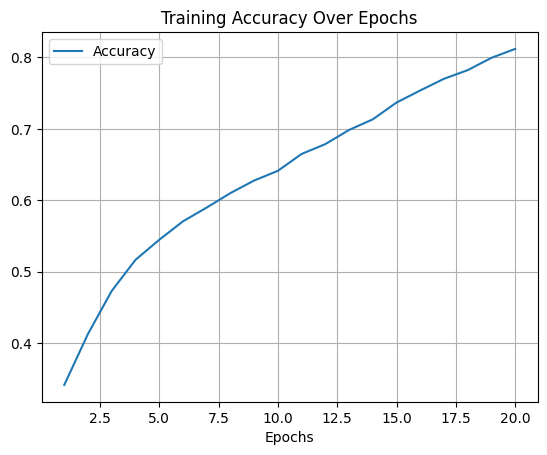


After first training session with 20 epochs, the accuracy reached 81%.  Now tweak the hyperparameters and run the program again.









After second training session with 100 epochs, the accuracy reached 95% within the first 40 epochs, but training speed slowed quickly from there.  Accuracy lowered the first time between 42 and 43.  Seems to stall out around 96%  Epochs should be around 70 in the future


97% reached at 65 epochs.  Between 65 and 100 epochs there was not significant increase in 



100 Epochs took approximately: 86min 

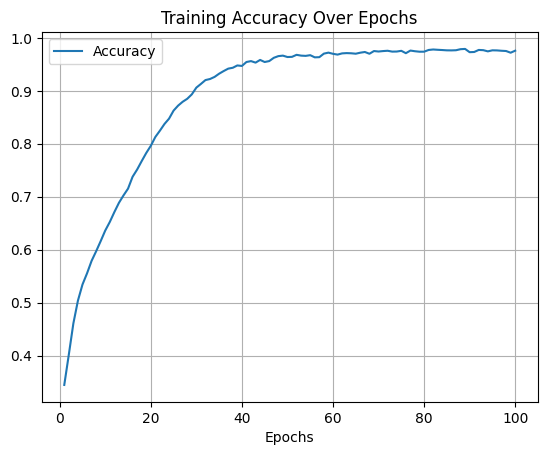


Restructured the model some to enhance performance.  100 Epochs is now taking around 10 minutes.


After more changes to hyperparameters, we were able to get to Epoch [20], Loss: 0.0725, Accuracy: 0.9752

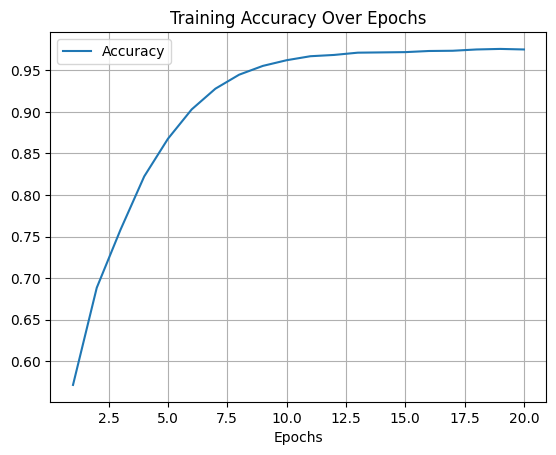



And a testing accuracy of 75
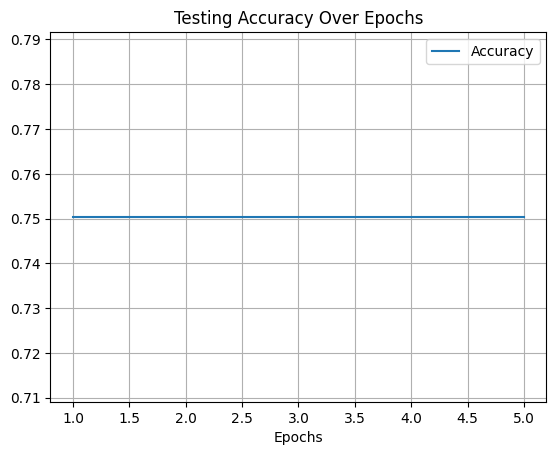

Save the parameters

In [ ]:
torch.save(bert_classifier.state_dict(), 'Bert_Classifier.pt')

Load the saved model in:

In [ ]:
# Rebuild full model
bert_base = DualBertModel(config)
bert_classifier = BertClassifier(bert_model=bert_base, hidden_dim=64, output_dim=num_classes)

# Load the model state dict
bert_classifier.load_state_dict(torch.load("bert_classifier.pt", map_location=device))

# Move to device and set to eval mode
bert_classifier.to(device)
bert_classifier.eval()


Now lets test the model. 

In [15]:
bert_classifier.eval()
test(bert_classifier, test_loader, criterion, device, test_epochs)



KeyboardInterrupt: 